In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import pandas as pd
import math

In [2]:
class HLA_Antigen_Cross(nn.Module):
    def __init__(self, input_dim=21, seq_len_1=35, seq_len_2=35, d_model=64):
        super(HLA_Antigen_Cross, self).__init__()
        self.seq_len_1 = seq_len_1
        self.seq_len_2 = seq_len_2
        self.d_model = d_model
        self.linear_in = nn.Linear(input_dim, d_model)
        self.cross_attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=2, batch_first=True, dropout=0.1)
        self.layer_norm = nn.LayerNorm(d_model)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(d_model * 4, d_model)
        )

    def forward(self, x1, x2):
        pos_1 = self.create_sinusoidal_embeddings(x1.size(0), self.seq_len_1, self.d_model).to(x1.device)
        pos_2 = self.create_sinusoidal_embeddings(x2.size(0), self.seq_len_2, self.d_model).to(x2.device)
        x1 = self.linear_in(x1) + pos_1
        x2 = self.linear_in(x2) + pos_2
        attn_output, _ = self.cross_attn(query=x1, key=x2, value=x2)
        x1_x2_attn_norm = self.layer_norm(attn_output + x1 + x2)
        ff_output = self.feed_forward(x1_x2_attn_norm)
        output = self.layer_norm(ff_output + x1_x2_attn_norm)
        return output

    @staticmethod
    def create_sinusoidal_embeddings(batch_size, n_position, d_model):
        position = torch.arange(0, n_position).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(batch_size, n_position, d_model)
        pe[:, :, 0::2] = torch.sin(position * div_term)
        pe[:, :, 1::2] = torch.cos(position * div_term)
        return pe

class pHLA_Model(nn.Module):
    def __init__(self):
        super(pHLA_Model, self).__init__()
        self.cross_attention_module = HLA_Antigen_Cross()
        self.fc2 = nn.Sequential(
            nn.Linear(64 + 21*35 + 21*35, 2048),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(2048, 2048),
            nn.Sigmoid(),
            nn.Dropout(0.1),
            nn.Linear(2048, 1),
        )

    def forward(self, peptides, hla_seqs):
        cross_attn_output = self.cross_attention_module(peptides, hla_seqs)
        flat_peptides = peptides.view(peptides.size(0), -1)
        flat_hla_seqs = hla_seqs.view(hla_seqs.size(0), -1)
        combined_features = torch.cat([cross_attn_output.mean(dim=1), flat_peptides, flat_hla_seqs], dim=1)
        logits = self.fc2(combined_features)
        return logits

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = pHLA_Model().to(device)
model.load_state_dict(torch.load('/kaggle/input/antigen-hla-cross-attention/best_model.pth'))
encoder = model.cross_attention_module

In [4]:
neg_training_path = '/kaggle/input/ca-tcrdata/neg_training.csv'
pos_training_path = '/kaggle/input/ca-tcrdata/pos_training.csv'
test_neg_path = '/kaggle/input/ca-tcrdata/test_neg.csv'
test_input_path = '/kaggle/input/ca-tcrdata/test_pos.csv'
neg_training = pd.read_csv(neg_training_path)
pos_training = pd.read_csv(pos_training_path)
test_neg = pd.read_csv(test_neg_path)
test_input = pd.read_csv(test_input_path)
neg_training['label'] = 0
pos_training['label'] = 1
test_neg['label'] = 0
test_input['label'] = 1
train_data = pd.concat([neg_training, pos_training], ignore_index=True)
test_data = pd.concat([test_neg, test_input], ignore_index=True)
hla_data = pd.read_csv('/kaggle/input/ca-tcrdata/updated_common_hla_sequence.csv')
hla_to_sequence = hla_data.set_index('HLA')['HLA_sequence'].to_dict()
train_data['HLA_sequence'] = train_data['HLA'].map(hla_to_sequence)
test_data['HLA_sequence'] = test_data['HLA'].map(hla_to_sequence)
train_data = train_data.dropna()
test_data = test_data.dropna()

In [5]:
aa_dict_one_hot_map = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7, 'K': 8, 'L': 9,
                       'M': 10, 'N': 11, 'P': 12, 'Q': 13, 'R': 14, 'S': 15, 'T': 16, 'V': 17,
                       'W': 18, 'Y': 19, 'X': 20}
def aa_dict_one_hot(sequence, max_length=35):
    encoded = np.zeros((21, max_length))
    for idx, aa in enumerate(sequence[:max_length]):
        if aa in aa_dict_one_hot_map:
            encoded[aa_dict_one_hot_map[aa], idx] = 1
    return encoded.T
def prepare_dataset(data):
    TCR = torch.stack([torch.Tensor(aa_dict_one_hot(seq)) for seq in data['CDR3']])
    Antigen = torch.stack([torch.Tensor(aa_dict_one_hot(seq)) for seq in data['Antigen']])
    HLA = torch.stack([torch.Tensor(aa_dict_one_hot(seq)) for seq in data['HLA_sequence']])
    labels = torch.Tensor(data['label'].values)
    return TensorDataset(TCR, Antigen, HLA, labels)

Train = prepare_dataset(train_data)
Test = prepare_dataset(test_data)
print(f'Loaded Train size: {len(Train)}')
train_size = int(0.8 * len(Train))
val_size = len(Train) - train_size
train_dataset, val_dataset = random_split(Train, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Loaded Train size: 595980


In [6]:
class pMHC_TCR_Cross(nn.Module):
    def __init__(self, input_dim_1=64, input_dim_2=21, seq_len_1=35, seq_len_2=35, d_model=128):
        super(pMHC_TCR_Cross, self).__init__()
        self.seq_len_1 = seq_len_1
        self.seq_len_2 = seq_len_2
        self.d_model = d_model
        self.linear_in_1 = nn.Linear(input_dim_1, d_model)
        self.linear_in_2 = nn.Sequential(
            nn.Linear(input_dim_2, input_dim_2 * 2),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(input_dim_2 * 2, d_model)
        )
        self.cross_attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=4, batch_first=True, dropout=0.1)
        self.layer_norm = nn.LayerNorm(d_model)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(d_model * 4, d_model)
        )

    def forward(self, x1, x2):
        pos_2 = self.create_sinusoidal_embeddings(x2.size(0), self.seq_len_2, self.d_model).to(x2.device)
        x1 = self.linear_in_1(x1)
        x2 = self.linear_in_2(x2) + pos_2
        attn_output, _ = self.cross_attn(query=x1, key=x2, value=x2)
        x1_x2_attn_norm = self.layer_norm(attn_output + x1 + x2)
        ff_output = self.feed_forward(x1_x2_attn_norm)
        output = self.layer_norm(ff_output + x1_x2_attn_norm)
        return output

    @staticmethod
    def create_sinusoidal_embeddings(batch_size, n_position, d_model):
        """Creates a tensor of sinusoidal positional embeddings for a specific batch size."""
        position = torch.arange(0, n_position).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(batch_size, n_position, d_model)
        pe[:, :, 0::2] = torch.sin(position * div_term)
        pe[:, :, 1::2] = torch.cos(position * div_term)
        return pe

In [7]:
class THACrossModel(nn.Module):
    def __init__(self):
        super(THACrossModel, self).__init__()
        input_features = 35*3*21 + 64 + 128
        self.fc_sequence = nn.Sequential(
            nn.Linear(input_features, 2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 1),
        )
        self.hla_antigen = encoder
        self.tcr_pMHC = pMHC_TCR_Cross()

    def forward(self, x_tcr, x_antigen, x_hla):
        x_tcr_flat = x_tcr.view(x_tcr.size(0), -1)
        x_antigen_flat = x_antigen.view(x_antigen.size(0), -1)
        x_hla_flat = x_hla.view(x_hla.size(0), -1)
        hla_antigen_matrix = self.hla_antigen(x_antigen, x_hla)
        hla_antigen_flat = hla_antigen_matrix.mean(dim=1)
        tcr_pMHC_matrix = self.tcr_pMHC(hla_antigen_matrix,x_tcr)
        tcr_pMHC_flat = tcr_pMHC_matrix.mean(dim=1)
        x = torch.cat((x_tcr_flat, x_antigen_flat, x_hla_flat, hla_antigen_flat, tcr_pMHC_flat), dim=1)
        out = self.fc_sequence(x)
        return out

In [8]:
def train(epoch, model, criterion, optimizer, train_loader, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for TCR, Antigen, HLA, labels in train_loader:
        TCR, Antigen, HLA, labels = TCR.to(device), Antigen.to(device),HLA.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(TCR, Antigen, HLA)
        outputs = outputs.squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predicted = (outputs > 0).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    print(f'Train Epoch: {epoch} Loss: {train_loss:.4f} Accuracy: {train_acc:.2f}%')
    return train_loss, train_acc

def validate(model, criterion, val_loader, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for TCR, Antigen, HLA, labels in val_loader:
            TCR, Antigen, HLA, labels = TCR.to(device), Antigen.to(device),HLA.to(device), labels.to(device)
            outputs = model(TCR, Antigen, HLA)
            outputs = outputs.squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            predicted = (outputs > 0).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    print(f'Validation Loss: {val_loss:.4f} Accuracy: {val_acc:.2f}%')
    return val_loss, val_acc

In [9]:
model = THACrossModel().to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
epochs = 200
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
best_val_acc = 0
no_improve_epochs = 0
patience = 10

for epoch in range(1, epochs + 1):
    train_loss, train_acc = train(epoch, model, criterion, optimizer, train_loader, device)
    val_loss, val_acc = validate(model, criterion, val_loader, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improve_epochs = 0
        model_path = f'HACAmodel_epoch_{epoch}_val_acc_{val_acc:.4f}_val_loss_{val_loss:.4f}.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
            'accuracy': val_acc
        }, model_path)
        print(f'Epoch {epoch}: New best validation accuracy achieved: {best_val_acc}. Model saved!')
    else:
        no_improve_epochs += 1
        print(f'Epoch {epoch}: No improvement in validation accuracy. {no_improve_epochs} epochs without improvement.')
    if no_improve_epochs >= patience:
        print(f'Stopping early after {epoch} epochs due to no improvement in validation accuracy.')
        break

THACrossModel(
  (fc_sequence): Sequential(
    (0): Linear(in_features=2397, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=2048, out_features=1024, bias=True)
    (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=1024, out_features=1, bias=True)
  )
  (hla_antigen): HLA_Antigen_Cross(
    (linear_in): Linear(in_features=21, out_features=64, bias=True)
    (cross_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
    )
    (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (feed_forward): Sequential(
      (0): Linear(in_features=64, out_features=256, bias=True)
      (1): ReLU

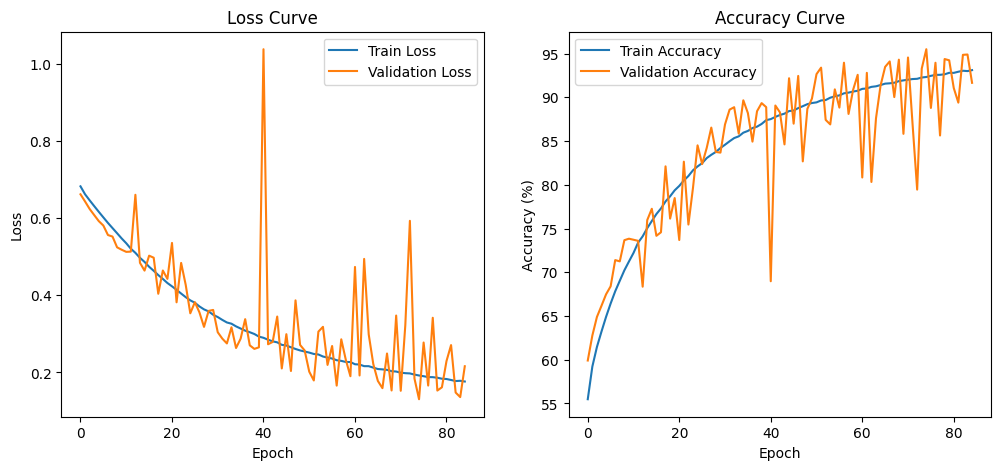

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

Loaded dataset size: 6127
Accuracy: 0.9131712094010119
MCC: 0.427396120520869
F1 Score: 0.4711729622266401
ROC AUC: 0.7052583569971217
PR AUC: 0.4903914254175155


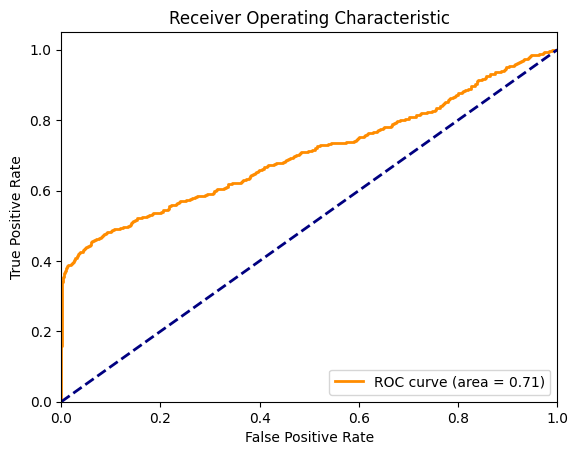

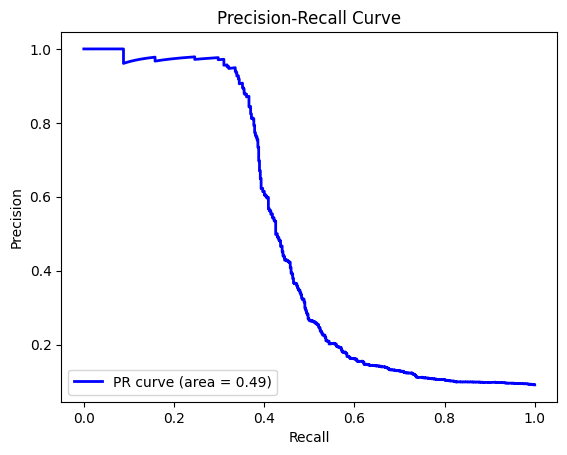

In [11]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, accuracy_score, matthews_corrcoef, f1_score
import numpy as np
print(f'Loaded dataset size: {len(Test)}')
test_loader = DataLoader(Test, batch_size=128, shuffle=True)
model.eval()
y_true = []
y_pred = []
y_score = []
with torch.no_grad():
    for TCR, Antigen, HLA, labels in test_loader:
        TCR, Antigen, HLA, labels = TCR.to(device), Antigen.to(device),HLA.to(device), labels.to(device)
        outputs = model(TCR, Antigen, HLA)
        predictions = torch.sigmoid(outputs).cpu().numpy()
        y_score.extend(predictions)
        y_pred.extend(predictions.round())
        y_true.extend(labels.cpu().numpy())
results_df = pd.DataFrame({
    'True': y_true,
    'Pred': y_pred,
    'Score': y_score
})
results_df.to_csv('fusion-pmt-test.csv', index=False)
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)
accuracy = accuracy_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(y_true, y_score)
pr_auc = auc(recall, precision)

print(f'Accuracy: {accuracy}')
print(f'MCC: {mcc}')
print(f'F1 Score: {f1}')
print(f'ROC AUC: {roc_auc}')
print(f'PR AUC: {pr_auc}')

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

plt.figure()
plt.plot(recall, precision, color='blue', lw=lw, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

Loaded dataset size: 10199
Accuracy: 0.7847828218452789
MCC: 0.10815901422285065
F1 Score: 0.20843851424450055
ROC AUC: 0.5610830307495478
PR AUC: 0.26978301027236823


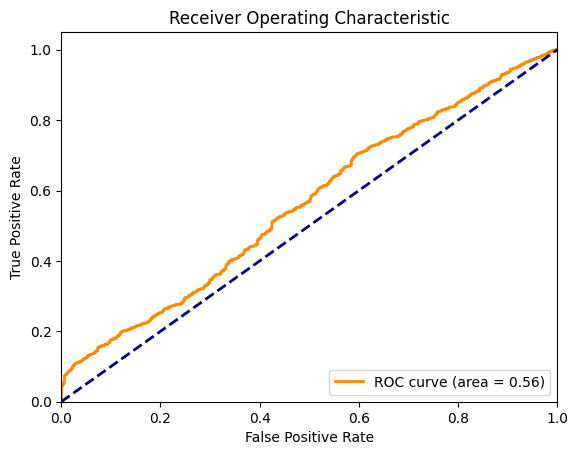

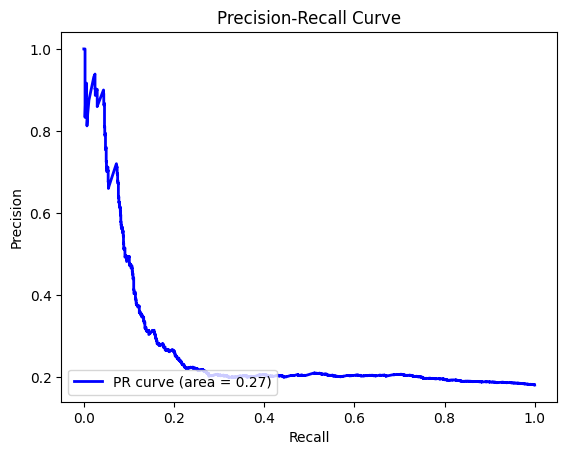

In [12]:
test_neg_path = '/kaggle/input/ca-tcrdata/Independent_Test_Neg.csv'
test_pos_path = '/kaggle/input/ca-tcrdata/Independent_Test_Pos.csv'

Independent_test_data_neg = pd.read_csv(test_neg_path)
Independent_test_data_pos = pd.read_csv(test_pos_path)

Independent_test_data_neg['label'] = 0
Independent_test_data_pos['label'] = 1
Independent_test_data = pd.concat([Independent_test_data_neg, Independent_test_data_pos], ignore_index=True)
Independent_test_data['HLA_sequence'] = Independent_test_data['HLA'].map(hla_to_sequence)
Independent_test_data = Independent_test_data.dropna()
Independent_test = prepare_dataset(Independent_test_data)
print(f'Loaded dataset size: {len(Independent_test)}')
test_loader = DataLoader(Independent_test, batch_size=128, shuffle=True)
model.eval()
y_true = []
y_pred = []
y_score = []
with torch.no_grad():
    for TCR, Antigen, HLA, labels in test_loader:
        TCR, Antigen, HLA, labels = TCR.to(device), Antigen.to(device),HLA.to(device), labels.to(device)
        outputs = model(TCR, Antigen, HLA)
        predictions = torch.sigmoid(outputs).cpu().numpy()
        y_score.extend(predictions)
        y_pred.extend(predictions.round())
        y_true.extend(labels.cpu().numpy())
results_df = pd.DataFrame({
    'True': y_true,
    'Pred': y_pred,
    'Score': y_score
})
results_df.to_csv('fusion-pmt-independ.csv', index=False)
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)
accuracy = accuracy_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(y_true, y_score)
pr_auc = auc(recall, precision)

print(f'Accuracy: {accuracy}')
print(f'MCC: {mcc}')
print(f'F1 Score: {f1}')
print(f'ROC AUC: {roc_auc}')
print(f'PR AUC: {pr_auc}')

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

plt.figure()
plt.plot(recall, precision, color='blue', lw=lw, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()